# Overview

The goal of this notebook is to run very basic Neural Network, GRU and LSTM and then compare their results and do in-depth analysis of their performance and decision. Depending on the result we will pick one model for later stages to do some hyper-parameter tuning and cross-validation in another notebook.

This basically demonstrates scratch implemntation and basic training efforets with predefined parameters and network architectures.

During the development, some parameters were changed but not tracked. For an example updating the embedding dim from 128 to 256 improved the GRU and LSTM results significantly. Adding higher dropout reduced overfitting and improved prediction.


## Contents
- Import Statements & Configurations
- Creating necessary functions
- Reading the clean data
- Creating data loaders
- Train Simple ANN
- Train GRU
- Train LSTM
- Performance analysis

### Import Statements

In [29]:
import warnings
warnings.filterwarnings("ignore")

import sys
import torch
import torch.nn as nn
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, precision_recall_curve,
    average_precision_score
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as _acc
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from loguru import logger




project_root = Path().resolve()
sys.path.append(str(project_root / "src"))

from dataset.custom_data import IMDBDataset
from models.dnn import DNN
from models.rnn import RNN
from models.lstm import LSTM


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Code is running on: {device}")

2025-08-10 21:32:16.210 | INFO     | __main__:<module>:36 - Code is running on: cuda


#### Configurations

In [2]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 120
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.width", None)

HTML("""
<style>
.container { width:100% !important; }
.output_png { display: block; margin-left: auto; margin-right: auto; }
</style>
""")

## Creating necessary functions

Below there are three functions written directly in the notebook. Some other functions are written in .py scripts. 

In [3]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total, loss_sum, correct = 0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.float().to(device)
        optimizer.zero_grad()
        logits = model(xb)                   # (B,)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        loss_sum += float(loss.item()) * yb.size(0)
        preds = (logits.sigmoid() >= 0.5).long()
        correct += (preds == yb.long()).sum().item()
        total += yb.size(0)
    return loss_sum/total, correct/total

In [4]:
@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    total, loss_sum, correct = 0, 0.0, 0
    all_y, all_p = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.float().to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss_sum += float(loss.item()) * yb.size(0)
        probs = logits.sigmoid()
        preds = (probs >= 0.5).long()
        correct += (preds == yb.long()).sum().item()
        total += yb.size(0)
        all_y.append(yb.cpu().numpy()); all_p.append(preds.cpu().numpy())
    y = np.concatenate(all_y); p = np.concatenate(all_p)
    return loss_sum/total, correct/total, y, p

In [5]:
def plot_history(history, best_epoch=None):
    epochs = history["epoch"]
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Loss
    axes[0].plot(epochs, history["train_loss"], label="Train")
    axes[0].plot(epochs, history["val_loss"],   label="Valid")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
    axes[0].legend()
    if best_epoch is not None and best_epoch in epochs:
        axes[0].axvline(best_epoch, ls="--", alpha=0.5)

    # Accuracy
    axes[1].plot(epochs, history["train_acc"], label="Train")
    axes[1].plot(epochs, history["val_acc"],   label="Valid")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    if best_epoch is not None and best_epoch in epochs:
        axes[1].axvline(best_epoch, ls="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


In [6]:
def make_snapshot_path(model, best_acc):
    snapshot_dir = project_root / "models"
    snapshot_dir.mkdir(parents=True, exist_ok=True)
    
    name = f"{model.__class__.__name__}_acc_{best_acc:.4f}.pt"
    return snapshot_dir / name

In [7]:
def model_trainer(model, optimizer, criterion):
    best_acc = 0.0
    patience = 3
    patience_counter = 0
    best_path = None
    best_epoch = None
    
    history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in tqdm(range(1, 11), desc="Epochs"):
        tr_loss, tr_acc = train_epoch(model, tqdm(train_loader, desc=f"Train {epoch}", leave=False),
                                      optimizer, criterion)
        te_loss, te_acc, y_true, y_pred = eval_epoch(model, tqdm(test_loader, desc=f"Eval  {epoch}", leave=False),
                                                     criterion)
    
        # log
        history["epoch"].append(epoch)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(te_loss)
        history["val_acc"].append(te_acc)
        
        tqdm.write(f"Epoch {epoch}: train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} "
                   f"val_loss={te_loss:.4f} val_acc={te_acc:.4f}")
    
        if te_acc > best_acc:
            best_acc = te_acc
            patience_counter = 0
            best_path = make_snapshot_path(model, best_acc)
            best_epoch = epoch
            torch.save(model.state_dict(), best_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                tqdm.write(f"Early stopping at epoch {epoch} (best val_acc={best_acc:.4f})")
                break
    
    # reload best
    assert best_path is not None
    model.load_state_dict(torch.load(best_path, map_location=device))
    
    # final report
    _, _, y_true, y_pred = eval_epoch(model, test_loader, criterion)
    logger.success(f"Best model: {best_path}")
    print(classification_report(y_true, y_pred, target_names=["neg","pos"]))
    
    plot_history(history, best_epoch=best_epoch)

### Reading clean data

In [8]:
df = pd.read_parquet(project_root / "data" / "imdb_reviews.parquet")
df = df[["review", "sentiment"]].dropna().reset_index(drop=True)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["review"].astype(str), df["sentiment"].astype(int), test_size=0.2, random_state=42, stratify=df["sentiment"]
)

### Creating Data Loaders

In [28]:
train_dataset = IMDBDataset(
    texts = X_train_text,
    labels = y_train,
    max_len=256, 
    preprocess=True, 
    min_freq=2, 
    max_vocab_size=30000, 
    language="english"
)


test_dataset = IMDBDataset(
    texts = X_test_text,
    labels = y_test,
    max_len=256, 
    preprocess=True, 
    min_freq=2, 
    max_vocab_size=30000, 
    language="english"
)


test_dataset.vocab = train_dataset.vocab



train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

#### Model Architecture - `DNN`

The DNN model is designed for sentiment/binary classification. It follows a simple yet effective feed-forward neural network structure that processes tokenized text inputs through an embedding layer, fully connected layers, and non-linear activations.

- Embedding Layer (`Embedding(30000, 128, padding_idx=0)`): Converts integer-encoded tokens into dense vector representations of size 128. The vocabulary size is capped at 30,000 tokens, with index 0 reserved for padding.
- First Fully Connected Layer (`Linear(128, 64)`): Reduces the embedding dimension from 128 to 64, enabling a compact intermediate representation.
- ReLU Activation: Introduces non-linearity to allow the model to capture complex relationships between input features.
- `Dropout (p=0.3)`: Randomly deactivates 30% of neurons during training to mitigate overfitting and improve generalization.
- Second Fully Connected Layer (`Linear(64, 1)`): Outputs a single logit value representing the sentiment polarity score for a given review. This logit is later passed through a sigmoid function during inference to obtain a probability in the range [0, 1].

DNN(
  (embedding): Embedding(30000, 128, padding_idx=0)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  1:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 1: train_loss=0.4569 train_acc=0.7938 val_loss=0.3136 val_acc=0.8718


Train 2:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  2:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 2: train_loss=0.2488 train_acc=0.9042 val_loss=0.2741 val_acc=0.8890


Train 3:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  3:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 3: train_loss=0.1846 train_acc=0.9333 val_loss=0.2730 val_acc=0.8919


Train 4:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  4:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 4: train_loss=0.1436 train_acc=0.9519 val_loss=0.2864 val_acc=0.8922


Train 5:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  5:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 5: train_loss=0.1116 train_acc=0.9643 val_loss=0.3130 val_acc=0.8904


Train 6:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  6:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 6: train_loss=0.0868 train_acc=0.9737 val_loss=0.3539 val_acc=0.8871


Train 7:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  7:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 7: train_loss=0.0658 train_acc=0.9809 val_loss=0.4023 val_acc=0.8841
Early stopping at epoch 7 (best val_acc=0.8922)


2025-08-10 21:33:16.466 | SUCCESS  | __main__:model_trainer:44 - Best model: J:\IMDB_Macromill\models\DNN_acc_0.8922.pt


              precision    recall  f1-score   support

         neg       0.90      0.88      0.89      4940
         pos       0.88      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



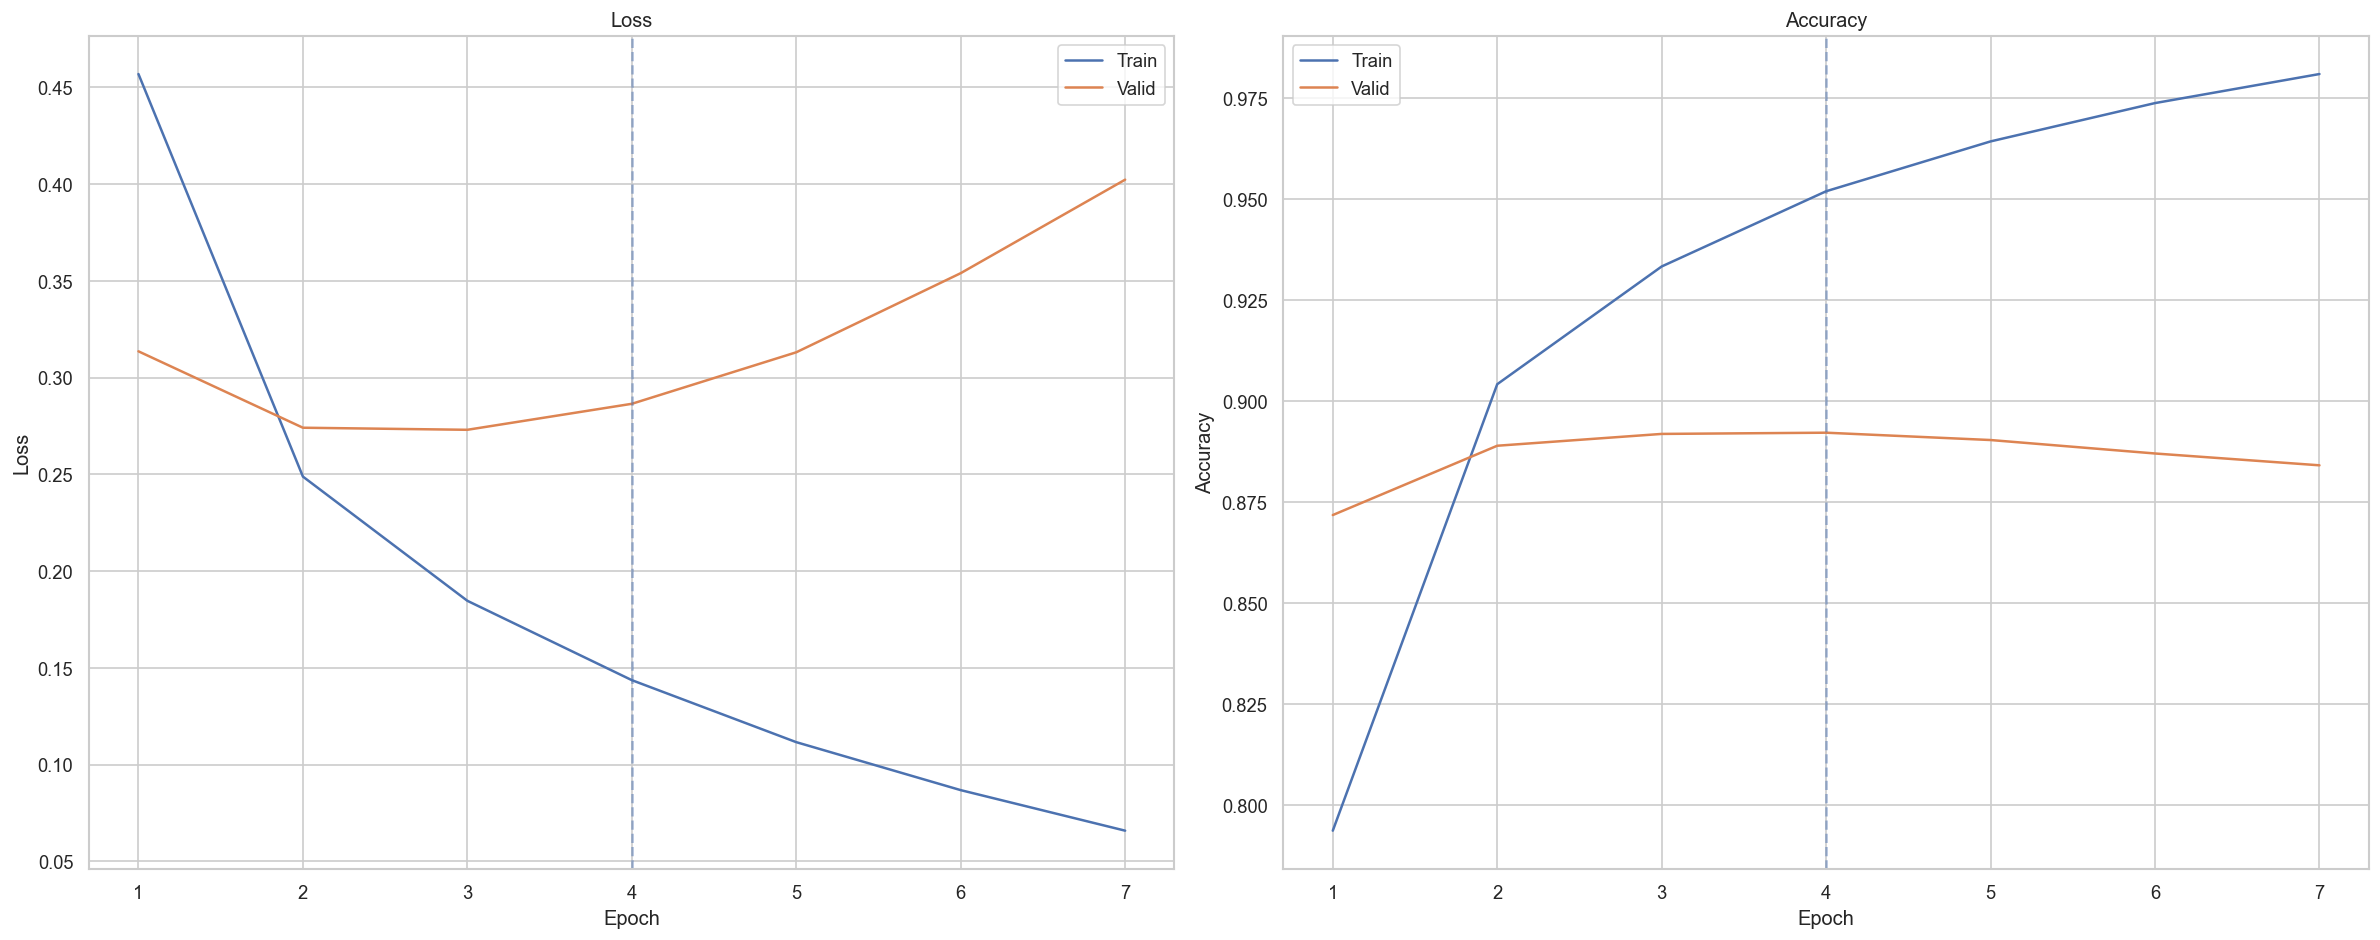

In [31]:
model_dnn = DNN(vocab_size=len(train_dataset.vocab), emb_dim=128, hidden_dim=64, dropout=0.3).to(device)
criterion_dnn = nn.BCEWithLogitsLoss()
optimizer_dnn = torch.optim.Adam(model_dnn.parameters(), lr=1e-3)

print(model_dnn)


model_trainer(model_dnn, optimizer_dnn, criterion_dnn)

#### Model Architecture - `RNN`

The RNN model is designed for sentiment/binary classification. It employs a recurrent neural network with gated recurrent units (GRUs) to capture sequential dependencies in tokenized text data, making it well-suited for tasks such as IMDb movie review sentiment analysis.
- Embedding Layer (`Embedding(30000, 256, padding_idx=0)`): Converts integer-encoded tokens into dense vector representations of size 256. The vocabulary size is capped at 30,000 tokens, with index 0 reserved for padding.
- Recurrent Layer (`GRU(256, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)`): Processes the sequence of embeddings using a two-layer GRU. The GRU is bidirectional, allowing it to capture context from both past and future tokens. Dropout of 0.3 is applied between layers to reduce overfitting.
- Dropout Layer (`Dropout(p=0.3)`): Further regularizes the model by randomly deactivating 30% of neurons during training.
- Fully Connected Layer (`Linear(512, 1)`): Maps the concatenated forward and backward GRU outputs (512 features) to a single logit value representing sentiment polarity. This logit is later passed through a sigmoid function during inference to obtain a probability in the range [0, 1].

RNN(
  (emb): Embedding(30000, 256, padding_idx=0)
  (rnn): GRU(256, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (drop): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  1:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5567 train_acc=0.7101 val_loss=0.4374 val_acc=0.8030


Train 2:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  2:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4079 train_acc=0.8194 val_loss=0.3435 val_acc=0.8525


Train 3:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  3:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 3: train_loss=0.2780 train_acc=0.8881 val_loss=0.3062 val_acc=0.8708


Train 4:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  4:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 4: train_loss=0.2089 train_acc=0.9204 val_loss=0.2789 val_acc=0.8893


Train 5:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  5:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 5: train_loss=0.1540 train_acc=0.9451 val_loss=0.3016 val_acc=0.8860


Train 6:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  6:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 6: train_loss=0.1109 train_acc=0.9626 val_loss=0.3302 val_acc=0.8825


Train 7:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  7:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 7: train_loss=0.0781 train_acc=0.9736 val_loss=0.3831 val_acc=0.8825
Early stopping at epoch 7 (best val_acc=0.8893)


2025-08-10 21:42:07.568 | SUCCESS  | __main__:model_trainer:44 - Best model: J:\IMDB_Macromill\models\RNN_acc_0.8893.pt


              precision    recall  f1-score   support

         neg       0.89      0.89      0.89      4940
         pos       0.89      0.89      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



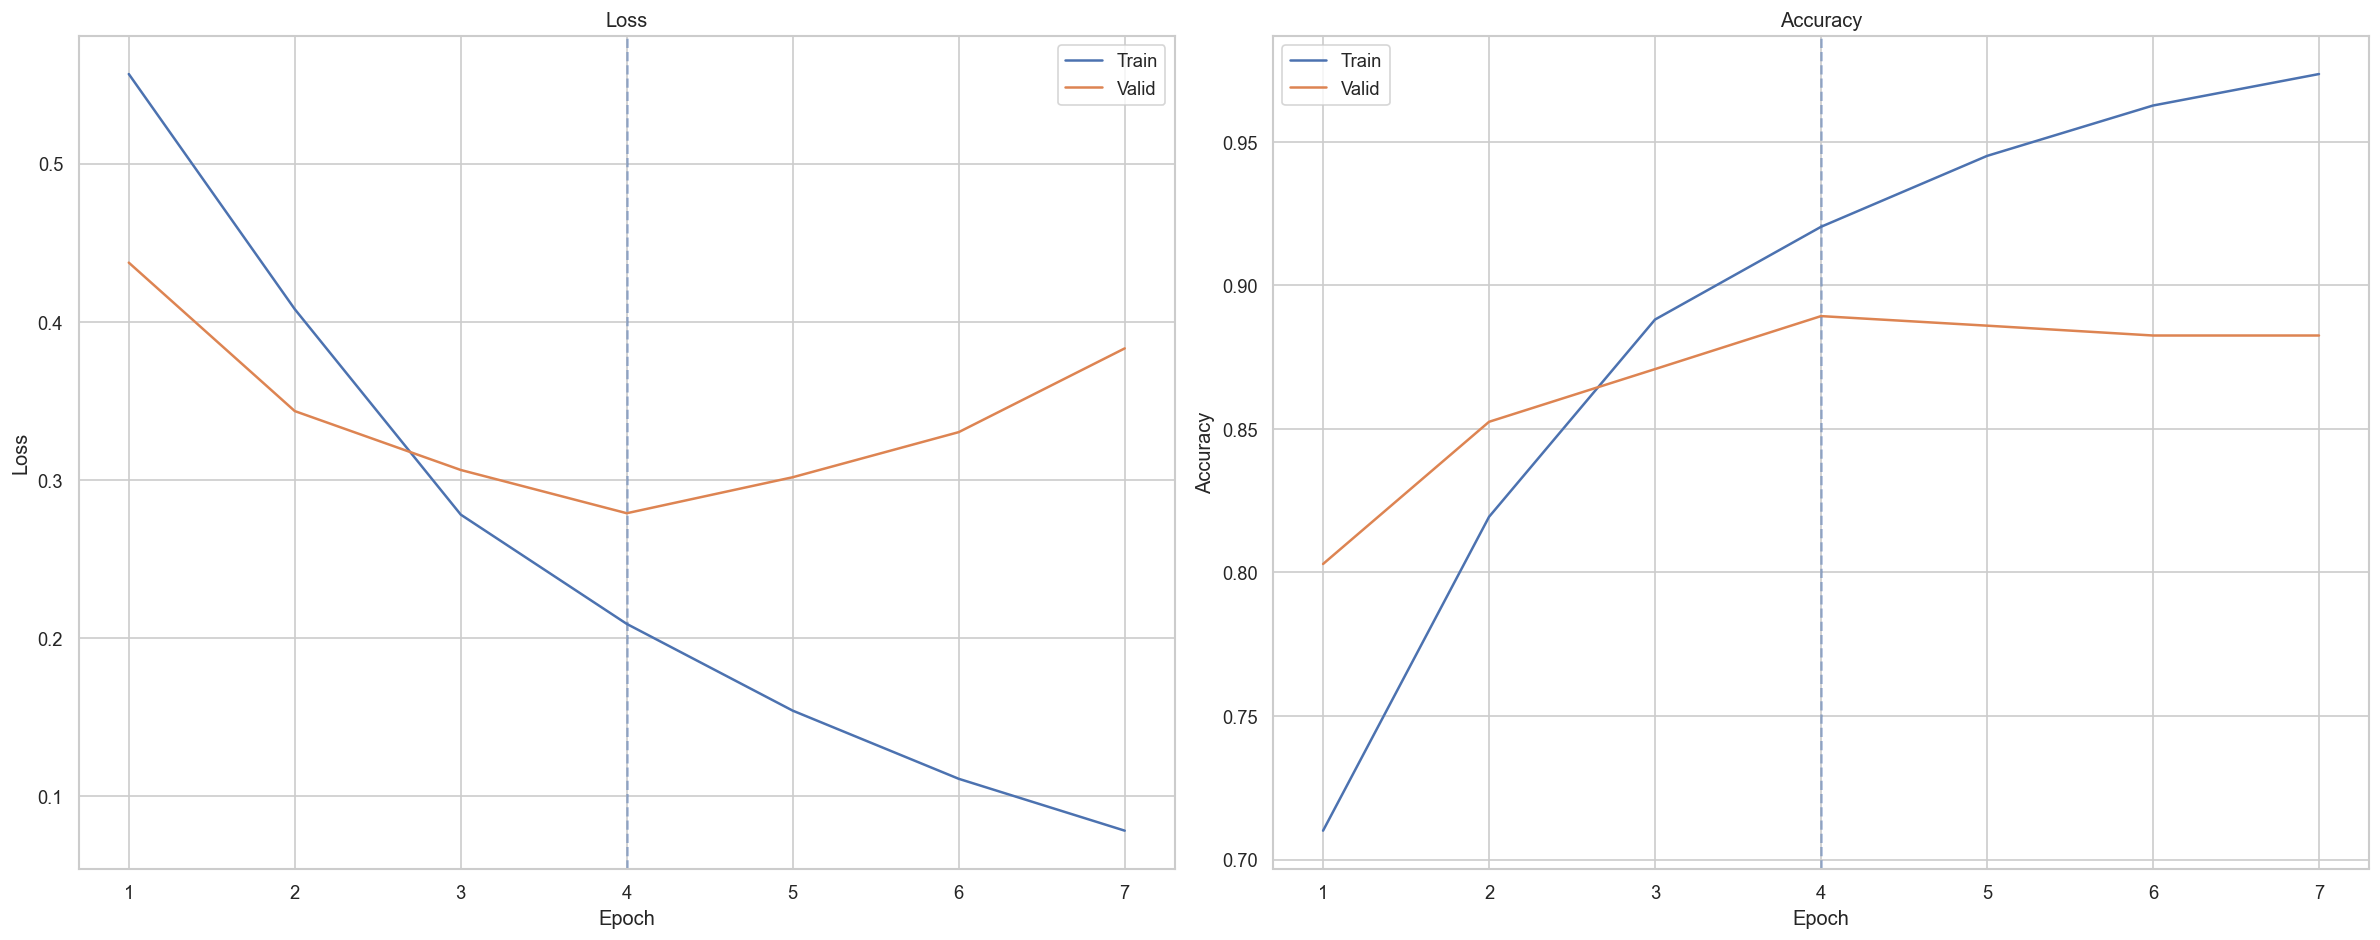

In [32]:
model_rnn = RNN(
    vocab_size=len(train_dataset.vocab),
    emb_dim=256,
    hidden_size=256,
    num_layers=2,
    bidirectional=True,
    dropout=0.3,
).to(device)

criterion_rnn = nn.BCEWithLogitsLoss()
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-4)

print(model_rnn)

model_trainer(model_rnn, optimizer_rnn, criterion_rnn)

#### Model Architecture - `LSTM`

The LSTM model is designed for sentiment/binary classification. It leverages Long Short-Term Memory (LSTM) networks to effectively capture long-range dependencies in sequential text data, making it suitable for tasks such as IMDb movie review sentiment analysis.
- **Embedding Layer (`Embedding(30000, 256, padding_idx=0):** Converts integer-encoded tokens into dense vector representations of size 256. The vocabulary size is capped at 30,000 tokens, with index `0` reserved for padding
- **Recurrent Layer (`LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=Tru`):** Processes the sequence of embeddings using a two-layer bidirectional LSTM. This allows the model to capture both past and future context in the text. A dropout rate of 0.4 is applied between LSTM layers for regularizatio
- **Dropout Layer (`Dropout(p=0)`):** Further reduces overfitting by randomly deactivating 40% of neurons during traini.
- **Fully Connected Layer (`Linear(2561)`):** Maps the concatenated forward and backward LSTM outputs (256 features) to a single logit value representing sentiment polarity. This logit is later passed through a sigmoid function during inference to obtain a probability in the range [0, 1].
].
y.

LSTM(
  (embedding): Embedding(30000, 256, padding_idx=0)
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train 1:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  1:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5423 train_acc=0.7275 val_loss=0.4071 val_acc=0.8272


Train 2:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  2:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 2: train_loss=0.3115 train_acc=0.8731 val_loss=0.2874 val_acc=0.8795


Train 3:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  3:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 3: train_loss=0.2026 train_acc=0.9264 val_loss=0.2907 val_acc=0.8894


Train 4:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  4:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 4: train_loss=0.1328 train_acc=0.9556 val_loss=0.3344 val_acc=0.8860


Train 5:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  5:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 5: train_loss=0.0798 train_acc=0.9753 val_loss=0.3996 val_acc=0.8894


Train 6:   0%|          | 0/620 [00:00<?, ?it/s]

Eval  6:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch 6: train_loss=0.0547 train_acc=0.9835 val_loss=0.3862 val_acc=0.8860
Early stopping at epoch 6 (best val_acc=0.8894)


2025-08-10 21:58:43.340 | SUCCESS  | __main__:model_trainer:44 - Best model: J:\IMDB_Macromill\models\LSTM_acc_0.8894.pt


              precision    recall  f1-score   support

         neg       0.91      0.87      0.89      4940
         pos       0.87      0.91      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



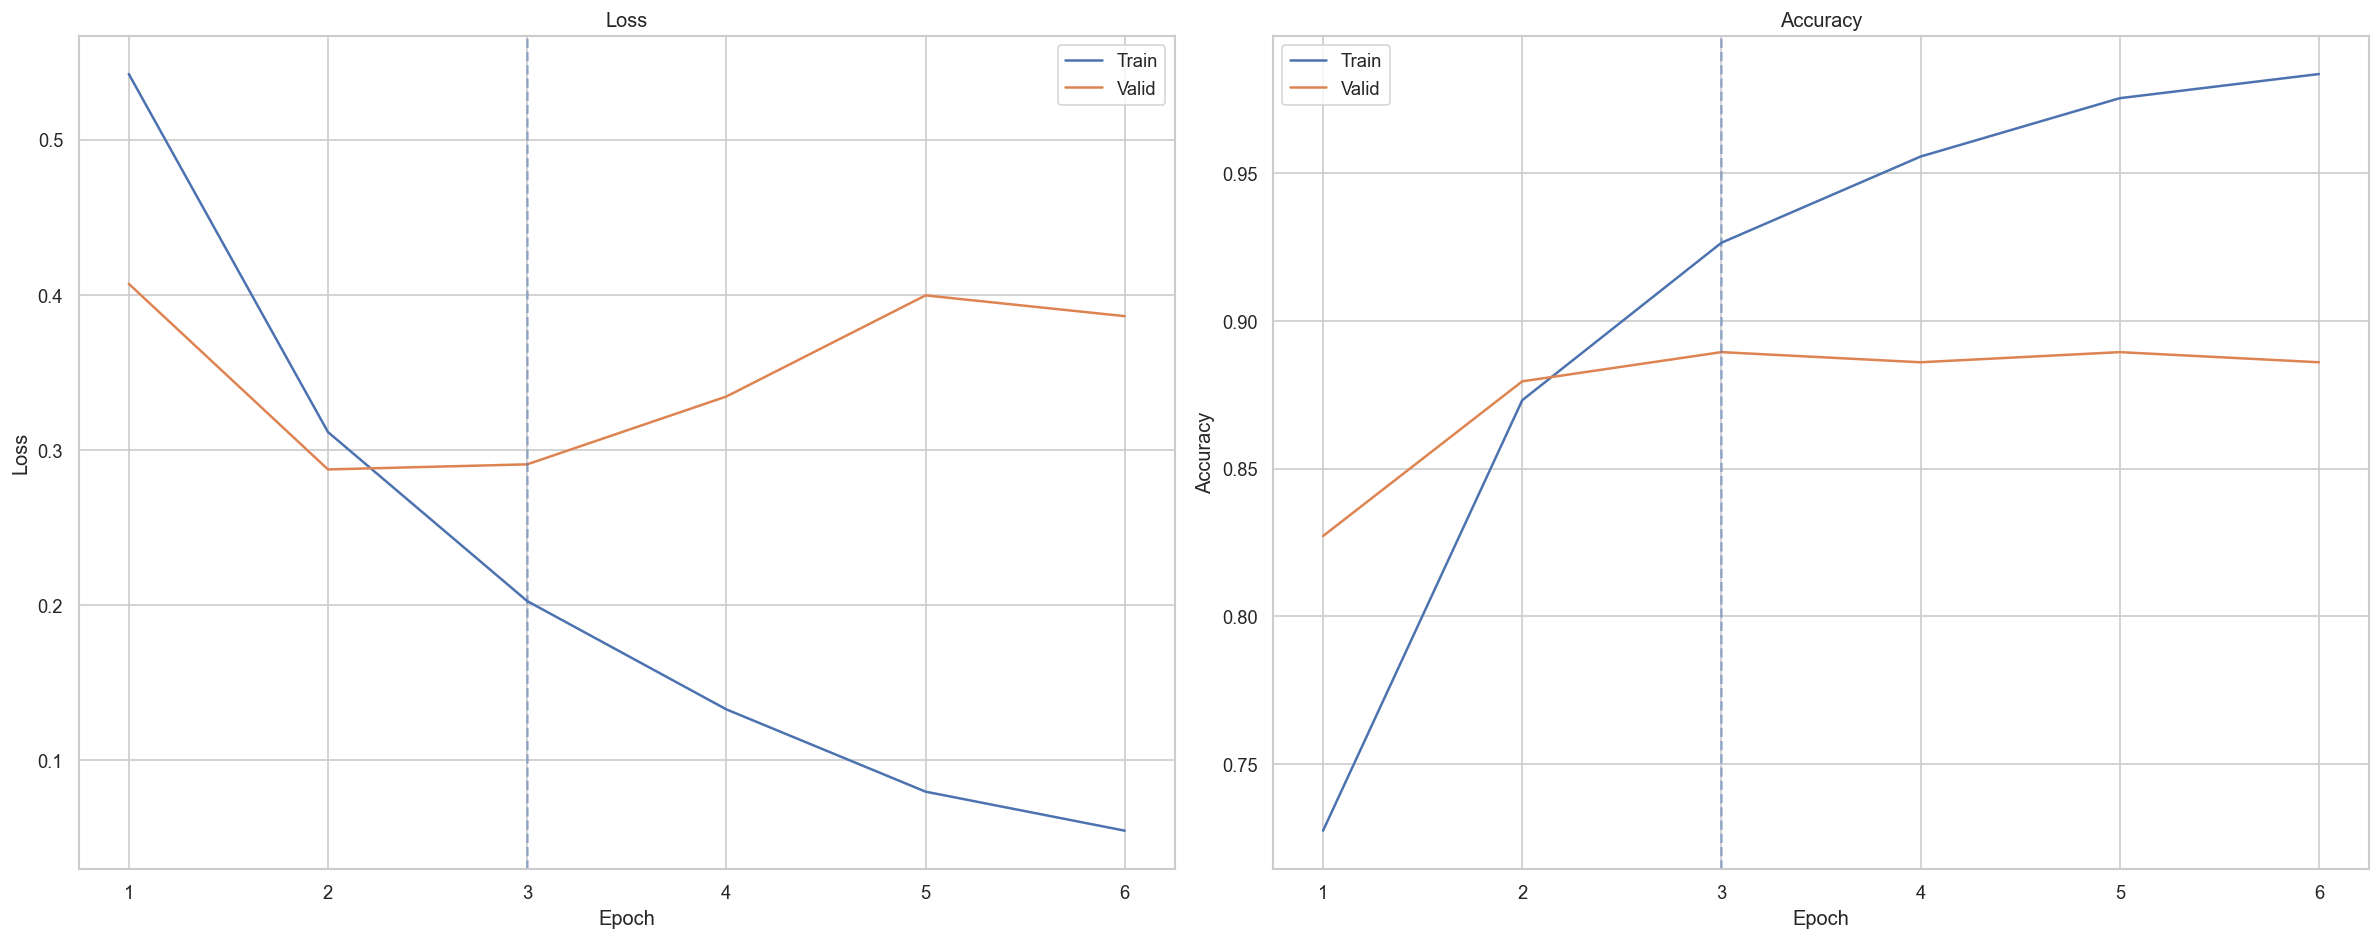

In [36]:
model_lstm = LSTM(
    vocab_size=len(train_dataset.vocab),
    emb_dim=256,
    hidden_dim=128,
    num_layers=2,
    bidirectional=True,
    dropout=0.4,
    pad_idx=0,
).to(device)

criterion_lstm = nn.BCEWithLogitsLoss()
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-3)

print(model_lstm)

model_trainer(model_lstm, optimizer_lstm, criterion_lstm)

In [14]:
from utils.model_utils import (
    evaluate_model, plot_cm_quadrant, plot_model_rocs, plot_model_prs,
    summarize_models, show_threshold_points_on_roc, plot_f1_vs_threshold
)

In [15]:
thresholds = [0.5, 0.6, 0.7, 0.8]
ev_dnn  = evaluate_model(model_dnn,  "DNN",  test_loader, device, thresholds)
ev_rnn  = evaluate_model(model_rnn,  "RNN",  test_loader, device, thresholds)
ev_lstm = evaluate_model(model_lstm, "LSTM", test_loader, device, thresholds)

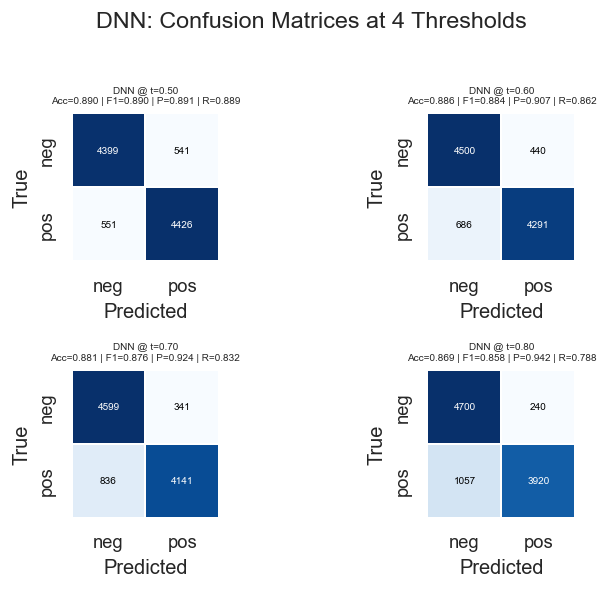

In [16]:
plot_cm_quadrant(ev_dnn); 

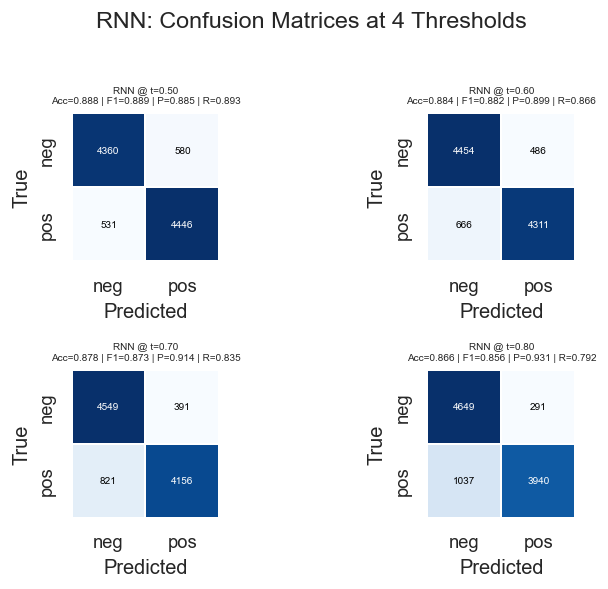

In [17]:
 plot_cm_quadrant(ev_rnn);  

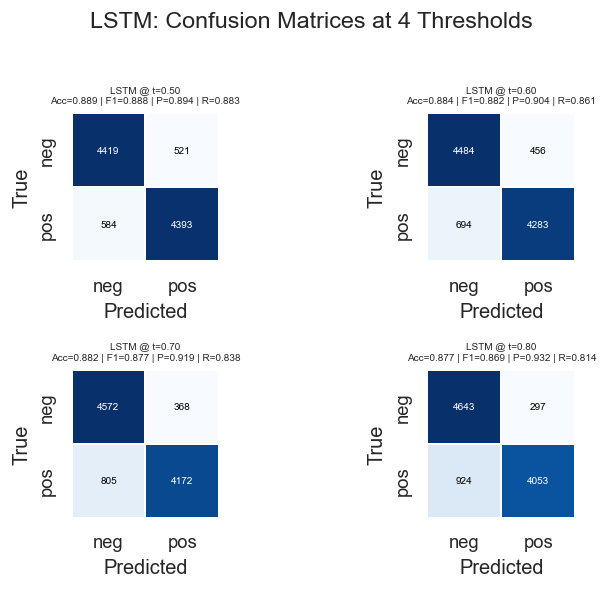

In [18]:
plot_cm_quadrant(ev_lstm)

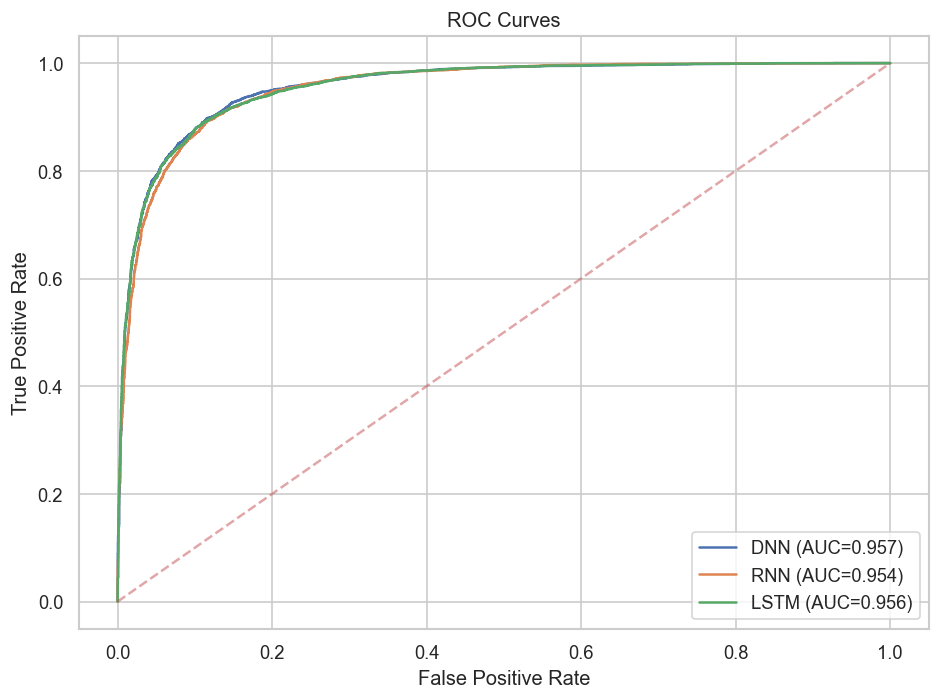

In [19]:
plot_model_rocs([ev_dnn, ev_rnn, ev_lstm]); 


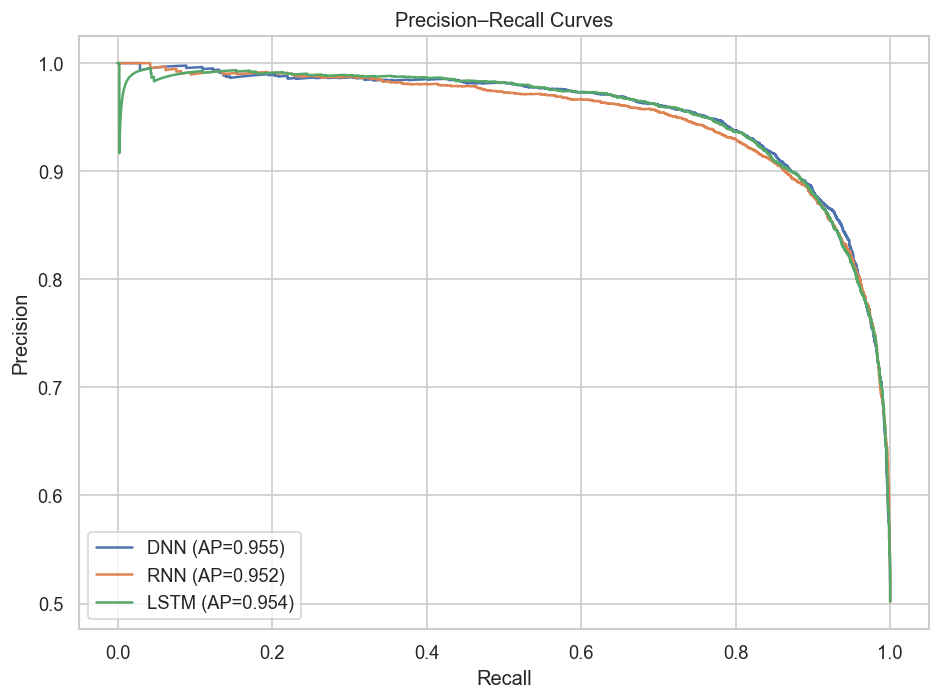

In [20]:
 plot_model_prs([ev_dnn, ev_rnn, ev_lstm])

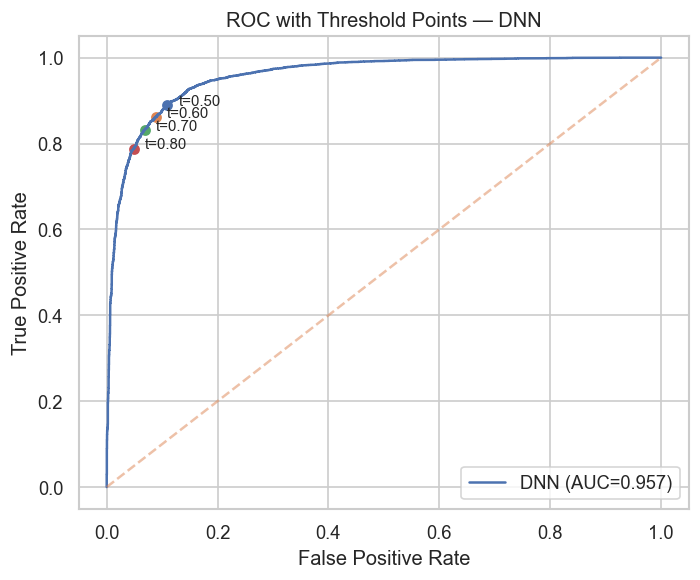

In [21]:
show_threshold_points_on_roc(ev_dnn)

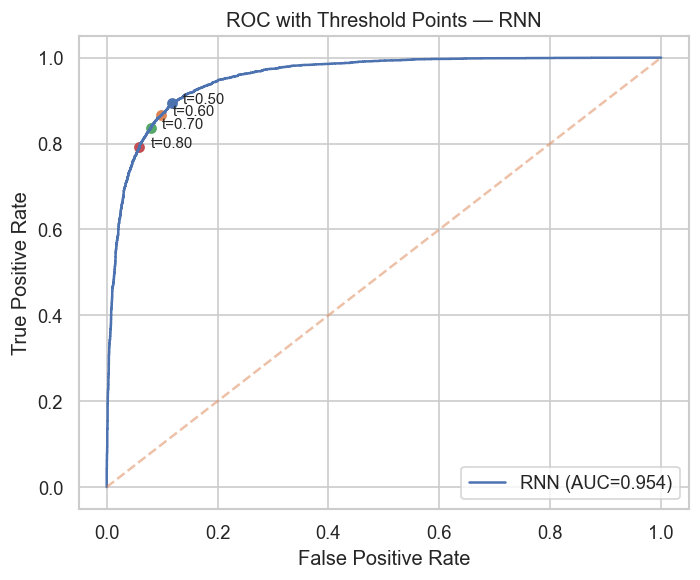

In [22]:
show_threshold_points_on_roc(ev_rnn)

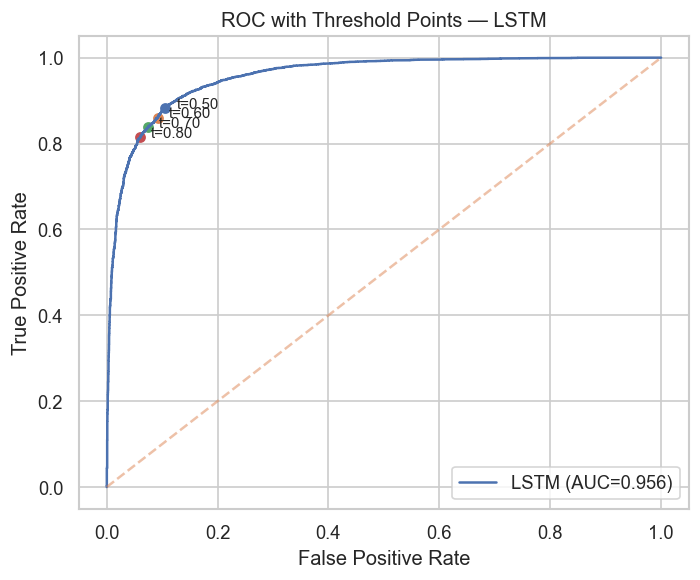

In [23]:
show_threshold_points_on_roc(ev_lstm)


In [24]:
per_threshold, leaderboard = summarize_models([ev_dnn, ev_rnn, ev_lstm])


In [25]:
display(per_threshold);


,model,threshold,accuracy,f1,precision,recall
0,DNN,0.5,0.889886,0.890185,0.891081,0.889291
1,DNN,0.6,0.886458,0.884013,0.906996,0.862166
2,DNN,0.7,0.881315,0.875568,0.923918,0.832027
3,DNN,0.8,0.869214,0.858050,0.942308,0.787623
4,RNN,0.5,0.887970,0.888933,0.884600,0.893309
5,RNN,0.6,0.883836,0.882136,0.898687,0.866184
6,RNN,0.7,0.877786,0.872743,0.914009,0.835041
7,RNN,0.8,0.866089,0.855778,0.931222,0.791642
8,LSTM,0.5,0.888575,0.888282,0.893976,0.882660
9,LSTM,0.6,0.884038,0.881639,0.903777,0.860559


In [26]:
 display(leaderboard)

,model,best_threshold,best_acc,best_f1,roc_auc,pr_auc
0,DNN,0.5,0.889886,0.890185,0.957052,0.955330
1,RNN,0.5,0.887970,0.888933,0.954269,0.951514
2,LSTM,0.5,0.888575,0.888282,0.956439,0.954472


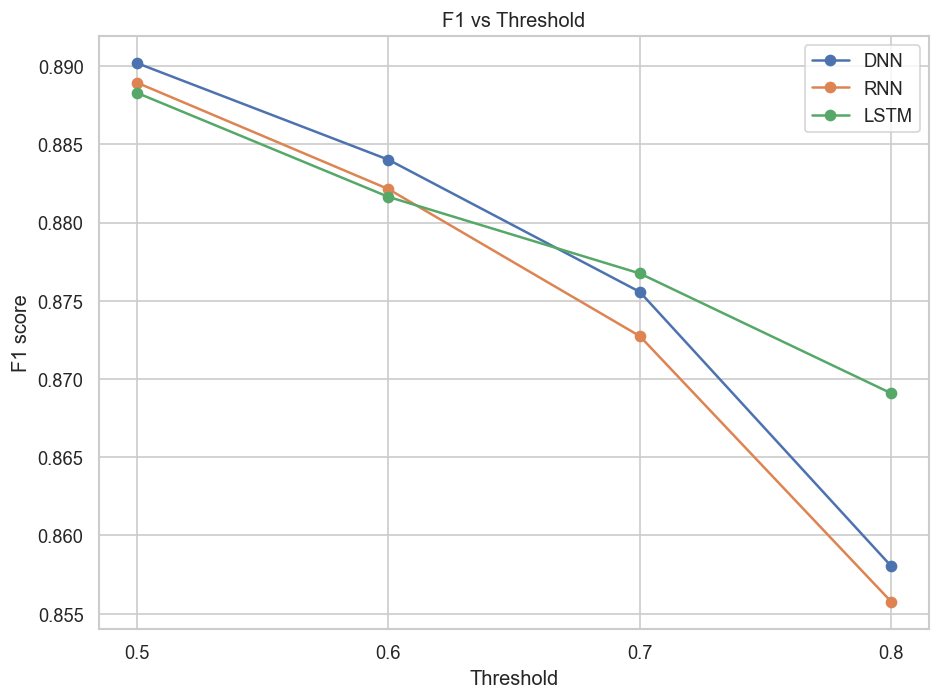

In [27]:
plot_f1_vs_threshold([ev_dnn, ev_rnn, ev_lstm])